## 1ACC0209-Data Mining Tools ##

## <h3 align="center"><b>TP:</b> NLP - Amazon Fine Food Reviews </h3>
<h3 align="center">2025-2</h3>

FUENTE: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews

1. CARGAR E INSPECCIONAR LOS DATOS

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
from collections import Counter
import html

#Bibliotecas para la modelización
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

from google.colab import files
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

In [4]:
data = 'Reviews.csv'
df = pd.read_csv(data)

In [5]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183457 entries, 0 to 183456
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      183457 non-null  int64 
 1   ProductId               183457 non-null  object
 2   UserId                  183457 non-null  object
 3   ProfileName             183445 non-null  object
 4   HelpfulnessNumerator    183457 non-null  int64 
 5   HelpfulnessDenominator  183457 non-null  int64 
 6   Score                   183457 non-null  int64 
 7   Time                    183457 non-null  int64 
 8   Summary                 183450 non-null  object
 9   Text                    183456 non-null  object
dtypes: int64(5), object(5)
memory usage: 14.0+ MB


In [7]:
df.shape

(183457, 10)

In [8]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,183457.000000,183457.000000,183457.000000,183457.000000,1.834570e+05
mean,91729.000000,1.669579,2.153605,4.169190,1.296215e+09
std,52959.618505,6.616213,7.234736,1.312429,4.769135e+07
min,1.000000,0.000000,0.000000,1.000000,9.393408e+08
25%,45865.000000,0.000000,0.000000,4.000000,1.271030e+09
50%,91729.000000,0.000000,1.000000,5.000000,1.310947e+09
75%,137593.000000,2.000000,2.000000,5.000000,1.332720e+09
max,183457.000000,559.000000,562.000000,5.000000,1.351210e+09


In [9]:
# Verificar valores nulos
df.isnull().sum()

,0
Id,0
ProductId,0
UserId,0
ProfileName,12
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,7
Text,1


In [10]:
# Contar valores únicos en la columna Score
df['Score'].value_counts()

,count
Score,
5,115629
4,26836
1,16917
3,14311
2,9764


2. Análisis exploratorio de los datos (EDA)

In [11]:
# Descargar stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
# 2. LIMPIEZA BÁSICA

# Eliminamos filas con texto o score faltantes
df = df.dropna(subset=['Text', 'Score'])

# Creamos una columna con la longitud del texto
df['TextLength'] = df['Text'].apply(lambda x: len(x.split()))

# Creamos una proporción de utilidad
df = df[df['HelpfulnessDenominator'] != 0]
df['HelpfulnessRatio'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']

/tmp/ipython-input-3344312240.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Score', data=df, palette='viridis')


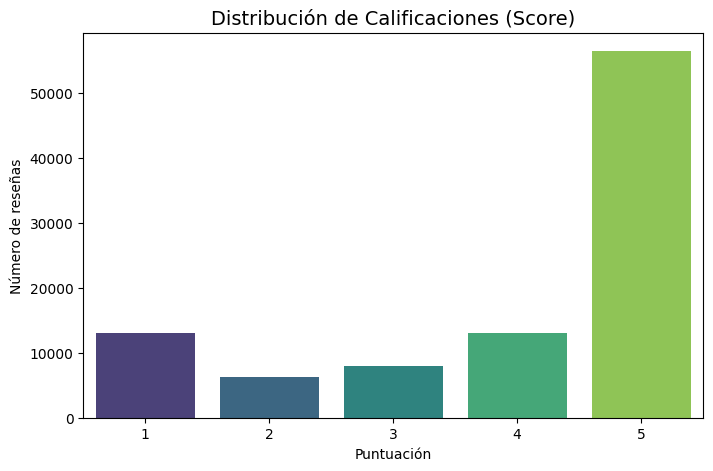

In [13]:
# 3. DISTRIBUCIÓN DE CALIFICACIONES

plt.figure(figsize=(8,5))
sns.countplot(x='Score', data=df, palette='viridis')
plt.title('Distribución de Calificaciones (Score)', fontsize=14)
plt.xlabel('Puntuación')
plt.ylabel('Número de reseñas')
plt.show()

/tmp/ipython-input-3503680571.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Score', y='HelpfulnessRatio', data=df, palette='coolwarm')


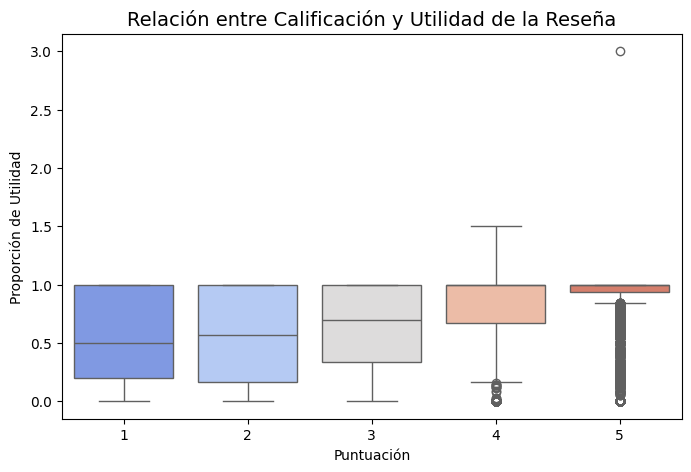

In [14]:
# 4. RELACIÓN ENTRE UTILIDAD Y CALIFICACIÓN

plt.figure(figsize=(8,5))
sns.boxplot(x='Score', y='HelpfulnessRatio', data=df, palette='coolwarm')
plt.title('Relación entre Calificación y Utilidad de la Reseña', fontsize=14)
plt.xlabel('Puntuación')
plt.ylabel('Proporción de Utilidad')
plt.show()

/tmp/ipython-input-1945013021.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Score', y='TextLength', data=df, palette='magma')


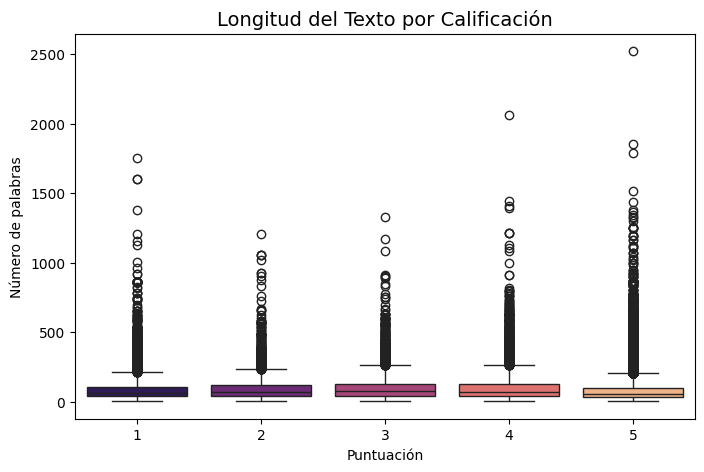

In [15]:
# 5. LONGITUD DE LAS RESEÑAS

plt.figure(figsize=(8,5))
sns.boxplot(x='Score', y='TextLength', data=df, palette='magma')
plt.title('Longitud del Texto por Calificación', fontsize=14)
plt.xlabel('Puntuación')
plt.ylabel('Número de palabras')
plt.show()

In [16]:
# 6. LIMPIEZA DE TEXTO PARA WORDCLOUD Y FRECUENCIA

stop_words = set(stopwords.words('english'))

def limpiar_texto(text):
    # 1. Decodificar caracteres HTML (&amp;, &lt;, etc.)
    text = html.unescape(text)
    # 2. Eliminar etiquetas HTML (como <br />)
    text = re.sub(r'<.*?>', ' ', text)
    # 3. Pasar a minúsculas
    text = text.lower()
    # 4. Eliminar números y caracteres no alfabéticos
    text = re.sub(r'[^a-z\s]', ' ', text)
    # 5. Quitar palabras vacías y tokens cortos (1-2 letras)
    words = [w for w in text.split() if w not in stop_words and len(w) > 2]
    return " ".join(words)

df['CleanText'] = df['Text'].apply(limpiar_texto)

/tmp/ipython-input-3478199857.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='Palabra', data=common_words, palette='crest')


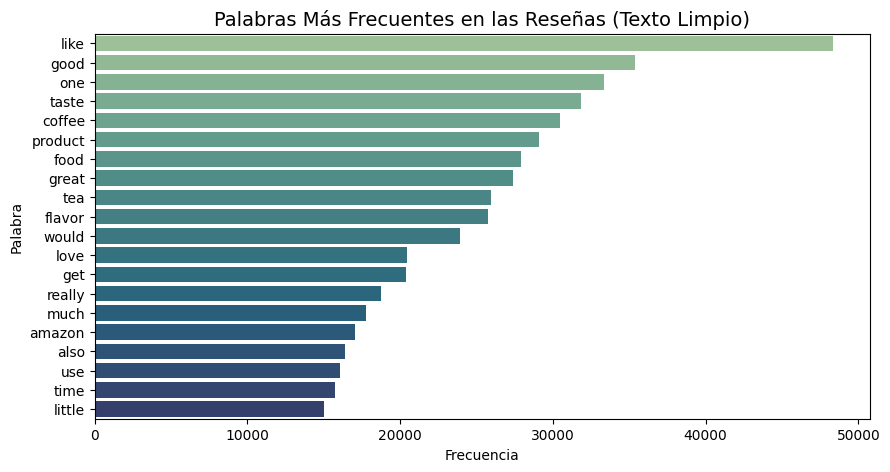

In [17]:
# 7. FRECUENCIA DE PALABRAS (TOP 20)

# Unir todos los textos
all_words = " ".join(df['CleanText']).split()

# Contar frecuencia
word_freq = Counter(all_words)

# Eliminar tokens residuales (como 'br', 'nbsp', etc.)
for token in ['br', 'nbsp', 'quot', 'http', 'www', 'com']:
    if token in word_freq:
        del word_freq[token]

# Crear DataFrame con top 20
common_words = pd.DataFrame(word_freq.most_common(20), columns=['Palabra', 'Frecuencia'])

plt.figure(figsize=(10,5))
sns.barplot(x='Frecuencia', y='Palabra', data=common_words, palette='crest')
plt.title('Palabras Más Frecuentes en las Reseñas (Texto Limpio)', fontsize=14)
plt.show()

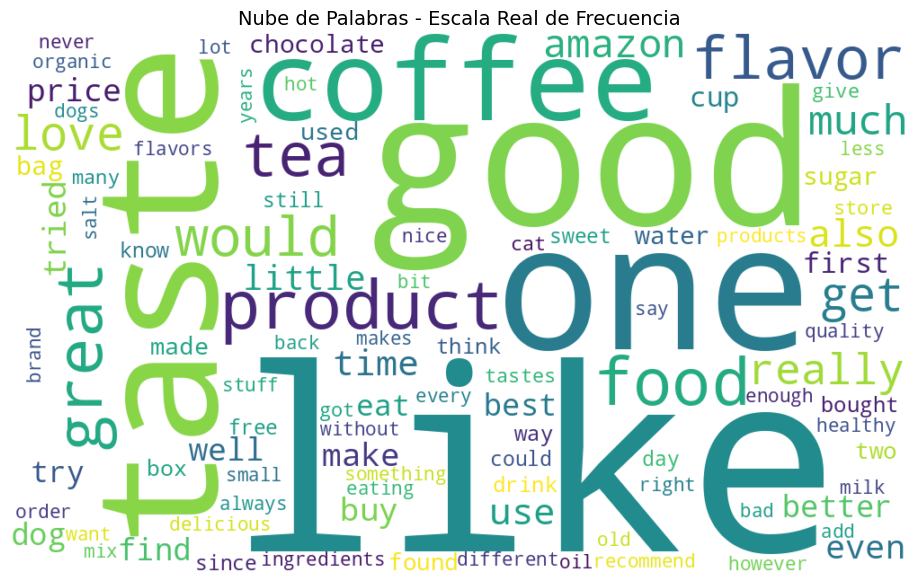

In [18]:
# 8. NUBE DE PALABRAS (WORD CLOUD)

word_freq_dict = dict(word_freq.most_common(100))

wordcloud = WordCloud(
    width=1000, height=600,
    background_color='white',
    collocations=False,
    stopwords=stop_words,
    relative_scaling=1.0,
    normalize_plurals=False
).generate_from_frequencies(word_freq_dict)

plt.figure(figsize=(12,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras - Escala Real de Frecuencia', fontsize=14)
plt.show()

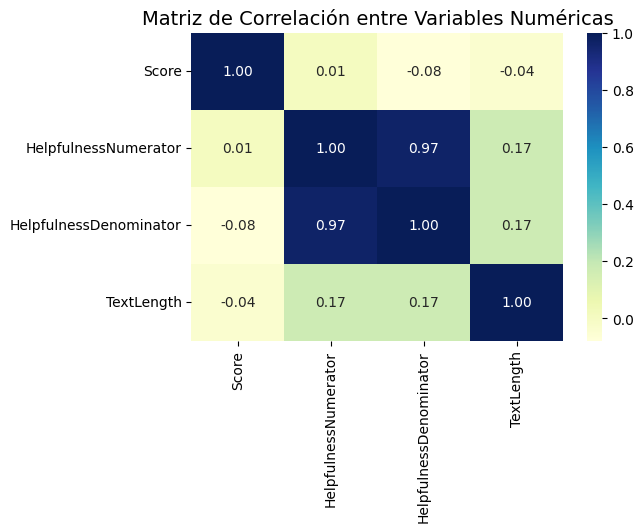

In [19]:
# 9. CORRELACIÓN ENTRE VARIABLES NUMÉRICAS

numeric_cols = ['Score', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'TextLength']
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Matriz de Correlación entre Variables Numéricas', fontsize=14)
plt.show()

In [20]:
# Exportar el dataset limpio
df[['Score', 'CleanText']].to_csv('reviews_clean.csv', index=False)
files.download('reviews_clean.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **MODELIZACIÓN**

## **Naive Bayes**

## Etapa 1 — Cargar datos y preparar conjuntos

In [21]:
# Cargar el CSV limpio
df = pd.read_csv('reviews_clean.csv')

# Eliminar nulos
df = df.dropna(subset=['CleanText'])

print("Distribución de Score:")
print(df['Score'].value_counts(normalize=True).sort_index())

# Definir variables
X = df['CleanText']
y = df['Score']

# División
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(f"\nTamaño del conjunto de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]}")


Distribución de Score:
Score
1    0.135101
2    0.064746
3    0.082580
4    0.134045
5    0.583527
Name: proportion, dtype: float64

Tamaño del conjunto de entrenamiento: 77287
Tamaño del conjunto de prueba: 19322


In [22]:
# Crear vectorizador
tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,2),
    min_df=5
)

# Transformar texto a vectores
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Modelo Naive Bayes
nb = MultinomialNB(alpha=1.0)
nb.fit(X_train_tfidf, y_train)

# Predicciones
y_pred_nb = nb.predict(X_test_tfidf)

# Reporte de métricas
print("NAIVE BAYES BASELINE")
print(classification_report(y_test, y_pred_nb, digits=3))


NAIVE BAYES BASELINE
              precision    recall  f1-score   support

           1      0.696     0.513     0.591      2610
           2      0.722     0.031     0.060      1251
           3      0.473     0.049     0.090      1596
           4      0.507     0.072     0.126      2590
           5      0.660     0.984     0.790     11275

    accuracy                          0.659     19322
   macro avg      0.612     0.330     0.331     19322
weighted avg      0.633     0.659     0.569     19322



## Etapa 3 — Matriz de confusión y visualización

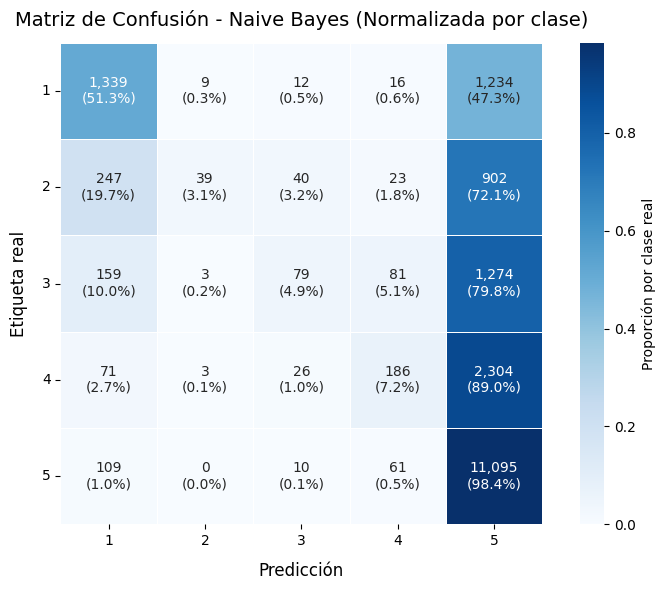

In [23]:
def plot_confusion_matrix_pretty(y_true, y_pred, labels=None, title="Matriz de Confusión - Naive Bayes"):
    if labels is None:
        labels = sorted(np.unique(np.concatenate([y_true, y_pred])))

    # Matriz cruda y normalizada por filas
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    cm_norm = np.nan_to_num(cm_norm)

    # Texto combinado
    annot = np.empty_like(cm).astype(object)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            pct = cm_norm[i, j] * 100
            annot[i, j] = f"{cm[i, j]:,}\n({pct:0.1f}%)"

    # Figura
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(
        cm_norm,
        annot=annot,
        fmt="",
        cmap="Blues",
        cbar=True,
        xticklabels=labels,
        yticklabels=labels,
        linewidths=.5,
        linecolor="white",
        square=True
    )

    # Títulos y ejes
    ax.set_xlabel("Predicción", fontsize=12, labelpad=10)
    ax.set_ylabel("Etiqueta real", fontsize=12, labelpad=10)
    ax.set_title(title, fontsize=14, pad=12)
    plt.xticks(fontsize=10, rotation=0)
    plt.yticks(fontsize=10, rotation=0)
    ax.figure.axes[-1].set_ylabel('Proporción por clase real', rotation=90, fontsize=10)
    plt.tight_layout()
    plt.show()

labels_sorted = sorted(df['Score'].unique())
plot_confusion_matrix_pretty(y_test, y_pred_nb, labels=labels_sorted,
                             title="Matriz de Confusión - Naive Bayes (Normalizada por clase)")


# Regresión Logística!

## Carga y split estratificado

In [24]:
# REGRESIÓN LOGÍSTICA (multiclase)

df = pd.read_csv('reviews_clean.csv').dropna(subset=['CleanText'])
X = df['CleanText']
y = df['Score']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

print(f"Train: {X_train.shape[0]} | Test: {X_test.shape[0]}")

Train: 77287 | Test: 19322


## Baseline: TF-IDF + LogisticRegression

In [25]:
baseline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=20000,
        ngram_range=(1,2),
        min_df=5
    )),
    ('lr', LogisticRegression(
        solver='saga',
        multi_class='multinomial',
        class_weight='balanced',
        max_iter=2000,
        n_jobs=-1,
        C=1.0,
        penalty='l2'
    ))
])

baseline_lr.fit(X_train, y_train)
y_pred_lr = baseline_lr.predict(X_test)

print("REGRESIÓN LOGÍSTICA - BASELINE")
print(classification_report(y_test, y_pred_lr, digits=3))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


REGRESIÓN LOGÍSTICA - BASELINE
              precision    recall  f1-score   support

           1      0.681     0.723     0.701      2610
           2      0.333     0.445     0.381      1251
           3      0.357     0.472     0.406      1596
           4      0.378     0.503     0.432      2590
           5      0.893     0.739     0.809     11275

    accuracy                          0.664     19322
   macro avg      0.528     0.576     0.546     19322
weighted avg      0.715     0.664     0.683     19322



# Matriz de confusión

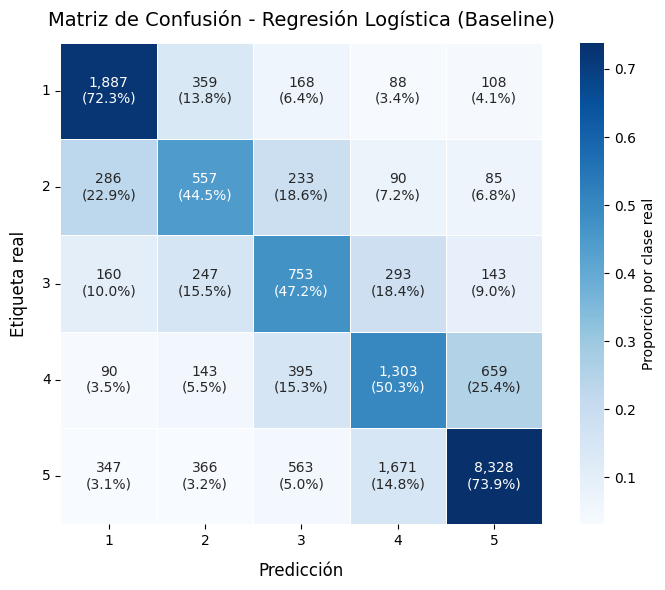

In [26]:
labels_sorted = sorted(df['Score'].unique())
plot_confusion_matrix_prety = plot_confusion_matrix_pretty

plot_confusion_matrix_pretty(
    y_test, y_pred_lr, labels=labels_sorted,
    title="Matriz de Confusión - Regresión Logística (Baseline)"
)

In [27]:
# 1) TF-IDF una sola vez (rápido)

tfidf_fast = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1,2),
    min_df=5
)
X_train_tfidf = tfidf_fast.fit_transform(X_train)
X_test_tfidf  = tfidf_fast.transform(X_test)

# 2) GridSearch mini (solo C) con 3 folds

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

lr_base = LogisticRegression(
    solver='saga',
    multi_class='multinomial',
    class_weight='balanced',
    max_iter=1500,
    n_jobs=-1
)

param_grid_fast = {
    'C': [0.5, 1.0, 2.0]
}

grid_fast = GridSearchCV(
    estimator=lr_base,
    param_grid=param_grid_fast,
    scoring='f1_weighted',
    cv=skf,
    n_jobs=-1,
    verbose=1
)

grid_fast.fit(X_train_tfidf, y_train)

print("Mejores params (rápido):", grid_fast.best_params_)
print("Mejor F1 (cv weighted):", grid_fast.best_score_)

# 3) Evaluación final en test

best_lr_fast = grid_fast.best_estimator_
y_pred_lr_fast = best_lr_fast.predict(X_test_tfidf)

print("\nREGRESIÓN LOGÍSTICA (Quick Tuned)")
print(classification_report(y_test, y_pred_lr_fast, digits=3))


Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Mejores params (rápido): {'C': 2.0}
Mejor F1 (cv weighted): 0.6711179545674645

REGRESIÓN LOGÍSTICA (Quick Tuned)
              precision    recall  f1-score   support

           1      0.663     0.741     0.700      2610
           2      0.365     0.425     0.393      1251
           3      0.371     0.465     0.413      1596
           4      0.372     0.538     0.440      2590
           5      0.895     0.730     0.805     11275

    accuracy                          0.664     19322
   macro avg      0.533     0.580     0.550     19322
weighted avg      0.716     0.664     0.682     19322



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [28]:
def resumen_metricas(y_true, y_pred, nombre):
    return {
        "Modelo": nombre,
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1 (weighted)": f1_score(y_true, y_pred, average='weighted'),
        "Precision (weighted)": precision_score(y_true, y_pred, average='weighted'),
        "Recall (weighted)": recall_score(y_true, y_pred, average='weighted')
    }

tabla = pd.DataFrame([
    resumen_metricas(y_test, y_pred_lr, "LR Baseline"),
    resumen_metricas(y_test, y_pred_lr_fast, "LR Tuned")
]).sort_values(by="F1 (weighted)", ascending=False)

print("\n Comparación LR:")
print(tabla)
tabla.to_csv("lr_metricas.csv", index=False)
print("Guardado: lr_metricas.csv")


 Comparación LR:
        Modelo  Accuracy  F1 (weighted)  Precision (weighted)  \
0  LR Baseline  0.663906       0.682718              0.714992   
1     LR Tuned  0.664424       0.682485              0.716127   

   Recall (weighted)  
0           0.663906  
1           0.664424  
Guardado: lr_metricas.csv


In [29]:
tfidf_vec = tfidf_fast
lr_clf = best_lr_fast
feature_names = np.array(tfidf_vec.get_feature_names_out())

classes = lr_clf.classes_
coefs = lr_clf.coef_

def top_terms_per_class(coefs, feature_names, k=20):
    out = {}
    for i, cls in enumerate(classes):
        top_idx = np.argsort(coefs[i])[-k:]
        out[int(cls)] = feature_names[top_idx][::-1].tolist()
    return out

top_terms = top_terms_per_class(coefs, feature_names, k=20)
for cls in sorted(top_terms.keys()):
    print(f"\nTop términos que empujan a Score={cls}:")
    print(", ".join(top_terms[cls]))


Top términos que empujan a Score=1:
worst, terrible, disgusting, awful, threw, horrible, nasty, even, rip, yuck, return, disappointment, waste, trash, money, disappointed, ruined, one star, cancelled, throw

Top términos que empujan a Score=2:
two stars, weak, disappointing, disappointed, excessive, unfortunately, weird, cannot recommend, diarrhea, cheaply, amount salt, marginally, terribly, upside, heating, bland, treat eat, stuffed, unfortunate, ive

Top términos que empujan a Score=3:
three stars, okay, however, stars, average, decent, prefer, twins, probably buy, like much, flying, petite, soupy, enough flavor, increased, decided try, tasted little, alright, cooled, overall

Top términos que empujan a Score=4:
four stars, complaint, good, stars, great, bit, nice, downside, tasty, excellent, overall, drawback, delicious, perfect, stars instead, reason give, gripe, enjoyed, pleasantly surprised, little

Top términos que empujan a Score=5:
delicious, best, great, perfect, excellent, 

# RANDOM FOREST

In [30]:
# Cargar y asegurar datos válidos
df = pd.read_csv('reviews_clean.csv').dropna(subset=['CleanText'])
X, y = df['CleanText'], df['Score']

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

print(f"Train: {X_train.shape[0]} | Test: {X_test.shape[0]}")

Train: 77287 | Test: 19322


In [31]:
# Parámetros
MAX_FEATS   = 8000
NGRAMS      = (1,1)
SVD_COMP    = 150
N_ESTIM     = 100
MAX_DEPTH   = 20
MIN_LEAF    = 2

rf_fast = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=MAX_FEATS, ngram_range=NGRAMS, min_df=5)),
    ('svd',   TruncatedSVD(n_components=SVD_COMP, random_state=42)),
    ('rf',    RandomForestClassifier(
                n_estimators=N_ESTIM,
                max_depth=MAX_DEPTH,
                min_samples_leaf=MIN_LEAF,
                n_jobs=-1,
                random_state=42
            ))
])

rf_fast.fit(X_train, y_train)
y_pred_rf = rf_fast.predict(X_test)

print("RANDOM FOREST (Fast Baseline)")
print(classification_report(y_test, y_pred_rf, digits=3))

RANDOM FOREST (Fast Baseline)
              precision    recall  f1-score   support

           1      0.797     0.438     0.566      2610
           2      0.997     0.238     0.385      1251
           3      0.987     0.242     0.389      1596
           4      0.976     0.254     0.403      2590
           5      0.678     0.994     0.806     11275

    accuracy                          0.708     19322
   macro avg      0.887     0.433     0.509     19322
weighted avg      0.780     0.708     0.658     19322



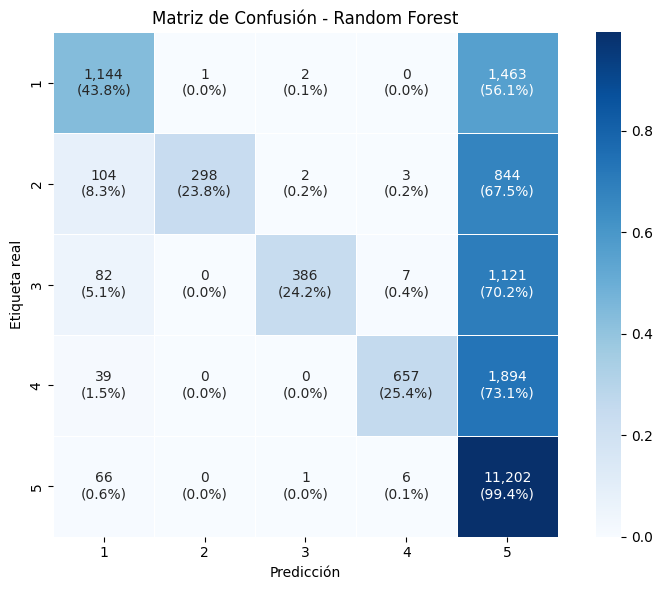

In [32]:
def plot_confusion_matrix_pretty(y_true, y_pred, labels=None, title="Matriz de Confusión - RF (Fast)"):
    if labels is None:
        labels = sorted(np.unique(np.concatenate([y_true, y_pred])))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    cm_norm = np.nan_to_num(cm_norm)
    annot = np.empty_like(cm, dtype=object)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f"{cm[i, j]:,}\n({cm_norm[i, j]*100:0.1f}%)"
    plt.figure(figsize=(8,6))
    ax = sns.heatmap(cm_norm, annot=annot, fmt="", cmap="Blues",
                     xticklabels=labels, yticklabels=labels,
                     linewidths=.5, linecolor="white", cbar=True, square=True)
    ax.set_xlabel("Predicción"); ax.set_ylabel("Etiqueta real")
    ax.set_title(title); plt.tight_layout(); plt.show()

labels_sorted = sorted(df['Score'].unique())
plot_confusion_matrix_pretty(y_test, y_pred_rf, labels=labels_sorted,
                             title="Matriz de Confusión - Random Forest")

In [33]:
res = {
    "Modelo": "Random Forest (Fast)",
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "F1 (weighted)": f1_score(y_test, y_pred_rf, average='weighted'),
    "Precision (weighted)": precision_score(y_test, y_pred_rf, average='weighted'),
    "Recall (weighted)": recall_score(y_test, y_pred_rf, average='weighted')
}

tabla_rf = pd.DataFrame([res])
print(tabla_rf)
tabla_rf.to_csv("rf_fast_metricas.csv", index=False)
print("Guardado: rf_fast_metricas.csv")

                 Modelo  Accuracy  F1 (weighted)  Precision (weighted)  \
0  Random Forest (Fast)  0.708364       0.657657              0.780206   

   Recall (weighted)  
0           0.708364  
Guardado: rf_fast_metricas.csv


Fitting 2 folds for each of 6 candidates, totalling 12 fits

Mejores params (rápido): {'svd__n_components': 100, 'rf__n_estimators': 100, 'rf__min_samples_leaf': 1, 'rf__max_depth': 20}

RF (Randomized Tuned)
              precision    recall  f1-score   support

           1      0.760     0.475     0.584      2610
           2      0.984     0.253     0.403      1251
           3      0.978     0.249     0.397      1596
           4      0.969     0.262     0.412      2590
           5      0.686     0.990     0.811     11275

    accuracy                          0.714     19322
   macro avg      0.875     0.446     0.521     19322
weighted avg      0.777     0.714     0.666     19322



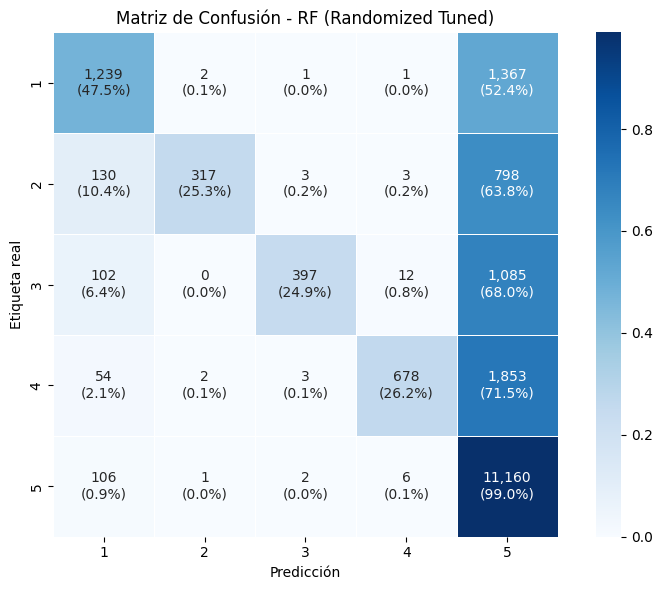

In [34]:
DO_TUNING = True

if DO_TUNING:
    skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
    param_dist = {
        'svd__n_components': [100, 150, 200],
        'rf__n_estimators' : [80, 100, 150],
        'rf__max_depth'    : [15, 20, None],
        'rf__min_samples_leaf': [1, 2, 3]
    }
    rnd = RandomizedSearchCV(
        estimator=rf_fast,
        param_distributions=param_dist,
        n_iter=6,
        scoring='f1_weighted',
        cv=skf, n_jobs=-1, random_state=42, verbose=1
    )
    rnd.fit(X_train, y_train)
    print("\nMejores params (rápido):", rnd.best_params_)
    y_pred_tuned = rnd.best_estimator_.predict(X_test)
    print("\nRF (Randomized Tuned)")
    print(classification_report(y_test, y_pred_tuned, digits=3))
    plot_confusion_matrix_pretty(y_test, y_pred_tuned, labels=labels_sorted,
                                 title="Matriz de Confusión - RF (Randomized Tuned)")


In [38]:
# Pipeline: TF-IDF + Red Neuronal
mlp_model = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=15000, ngram_range=(1,2), min_df=5)),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation='relu',
        solver='adam',
        max_iter=10,
        random_state=42
    ))
])

# Entrenamiento
mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_test)

print("RED NEURONAL (MLP) - BASELINE")
print(classification_report(y_test, y_pred_mlp, digits=3))

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


RED NEURONAL (MLP) - BASELINE
              precision    recall  f1-score   support

           1      0.729     0.711     0.720      2610
           2      0.455     0.416     0.434      1251
           3      0.456     0.436     0.446      1596
           4      0.502     0.450     0.475      2590
           5      0.844     0.882     0.862     11275

    accuracy                          0.734     19322
   macro avg      0.597     0.579     0.587     19322
weighted avg      0.725     0.734     0.729     19322

